# Discharge Notes and Readmission Rates: EDA

This notebook is for the initial exploratory data analysis of the dataset. Readmission is defined as anyone who were readmitted after 30 days of discharge from the last admissions. In addition, the readmission was an emergency.

## Import

Import all the relevant libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
#nlp libraries 
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
import string

#vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

In [2]:
#set the pandas display column width as max to read in all the text
#pd.set_option('display.max_colwidth', None)

## Overview

Hospital readmissions are costly for health systems and payers. The average readmission cost in 2016 was $14.4K. That is why one of the metrics payers use to assess healthcare systems and medical providers is 30-day readmission rates. The Centers for Medicare & Medicaid Services (CMS) has implemented the [Hospital Readmissions Reduction Program](https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AcuteInpatientPPS/Readmissions-Reduction-Program) (HRRP), which incentivizes providers by tying reimbursements with readmission rates. However, according to the [Agency for Healthcare Research and Quality (AHRQ)](https://www.hcup-us.ahrq.gov/reports/statbriefs/sb248-Hospital-Readmissions-2010-2016.jsp), readmission rates in the US has stayed relatively consistent from 2010 to 2016, as see in the figure below. Based on a [study](https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/2498846) conducted by the University of California San Francisco (UCSF), approximately 27% of 30-day readmissions are preventable.

In [3]:
#data from AHRQ, link in text above
X = [2010, 2011, 2012, 2013, 2014, 2015, 2016]

readmission = [14.2, 14.3, 14.1, 13.9, 13.9, 14.0, 13.9]

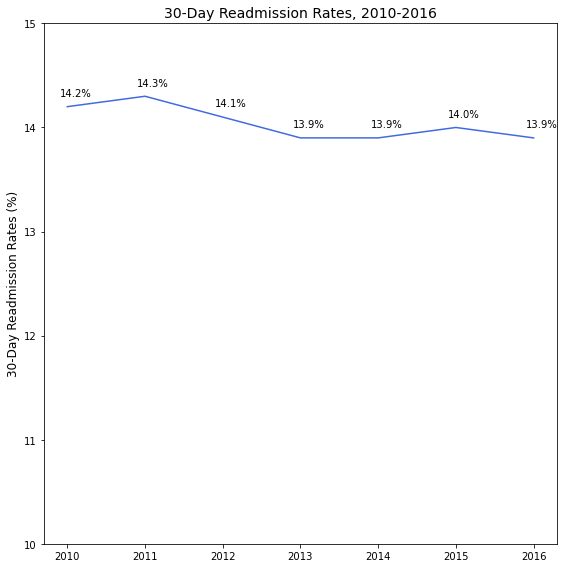

In [4]:
#create a figure
fig, ax = plt.subplots(figsize=(8,8))
#set background color to white
fig.patch.set_facecolor('white')
#create a bar graph
ax.plot(X, readmission, color='royalblue')
#set the title and axis label
ax.set_title('30-Day Readmission Rates, 2010-2016',fontsize=14)
ax.set_ylabel("30-Day Readmission Rates (%)", fontsize=12)
ax.set_ylim(bottom=10, top=15)

for i in range(len(X)):
    ax.annotate(str(readmission[i])+"%", xy=(X[i]-0.1, readmission[i]+0.1))
plt.tight_layout()
plt.show()

#save the figure in the images folder
fig.savefig('images/30_day_readmissions.png', bbox_inches='tight')

## Business Understanding

## Data Understanding

## Functions

This section is for any functions created for the analysis.

In [5]:
def group_categories(df, category):
    '''
    some of the datasets have multiple rows for diagnosis or ICD code per subject and admission ID
    in order to onehotencode it later, this function aggregates all the codes into a list, and then
    convert the list into a string separate by a comma
    
    the function takes in the dataframe which should only contain three columns: subject_id, hadm_id,
    and the category of interest; and the string for the column name of the cateogry of interest
    '''
    #group by the subject and admission ID
    group = df.groupby(['SUBJECT_ID', 'HADM_ID'])
    #create a list of all the values associated with the subject and admission ID
    result = group.agg({category:lambda x:list(set(x.tolist()))})
    result.reset_index(inplace=True)
    #convert the list into a string, separated by commas
    result[category] = [', '.join(map(str, l)) for l in result[category]]
    return result

In [6]:
stemmer = PorterStemmer()
def stem_text(text):
    '''
    This function takes a text and stem it
    '''
    return [stemmer.stem(w) for w in word_tokenize(text)]

In [7]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(token_text):
    '''
    This function takes an already tokenized text and lemmatize it
    '''
    return [lemmatizer.lemmatize(w) for w in token_text]

In [8]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

In [9]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Readmission', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()
    return fig

## Exploratory Data Analysis (EDA)

In this section, I focused on reviewing the datasets I am using for this project.

### Admission Data

The ADMISSIONS dataset has the information on the demographics of the patient. 

In [10]:
#read in the dataset
admit_df = pd.read_csv('data/ADMISSIONS.csv.gz', compression='gzip')

In [11]:
#review the columns in the dataset
admit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

In [12]:
#review the first 5 entires in the dataset
admit_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [13]:
#check what admission types are included
admit_df['ADMISSION_TYPE'].value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

In [14]:
#drop any irrelevant columns
columns_to_drop = ['DEATHTIME','EDREGTIME','EDOUTTIME']
admit_df.drop(columns_to_drop, axis=1, inplace=True)

In [15]:
#check how many unique patients
admit_df['SUBJECT_ID'].nunique()

46520

### Chart Notes

The NOTEEVENTS dataset has the chart notes, including discharge notes, per patient and admissions.

In [ ]:
#read in the dataset
notes_df = pd.read_csv('data/NOTEEVENTS.csv.gz', compression='gzip')

In [ ]:
#review the columns in the dataset
notes_df.info()

In [ ]:
#review the first 5 entires in the dataset
notes_df.head()

In [ ]:
notes_df['CATEGORY'].value_counts()

In [ ]:
#the column ISERROR, if the value is 1, indicates that a physician indicated that the notes are wrong
#drop any columns that do not have an error
notes_df = notes_df[notes_df['ISERROR'] != 1]
#isolate the discharge notes
notes_df = notes_df[notes_df['CATEGORY'] == 'Discharge summary']

In [ ]:
#drop any irrelevant columns
columns_to_drop = ['ROW_ID','CHARTDATE','CHARTTIME','STORETIME','CATEGORY','DESCRIPTION','CGID','ISERROR']
notes_df.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
#review the edited dataframe
notes_df.head()

In [ ]:
notes_df.info()

In [ ]:
#it seems like there are multiple discharge notes per subject and admission IDs
notes_df.duplicated(subset=['SUBJECT_ID','HADM_ID'], keep=False)

In [ ]:
#combine any texts that have the same SUBJECT_ID and HADM_ID
notes_df = group_categories(notes_df, 'TEXT')

In [ ]:
notes_df

### Additional Patient Data

The PATIENT dataset contains further information of the patient include date of birth and gender

In [ ]:
#read in the dataset
patients_df = pd.read_csv('data/PATIENTS.csv.gz', compression='gzip')

In [ ]:
#review the columns in the dataset
patients_df.info()

In [ ]:
#review the first 5 entires in the dataset
patients_df.head()

In [ ]:
#isolate the relevant columns
patients_df = patients_df[['SUBJECT_ID', 'GENDER', 'DOB']]

### CPT Codes

The CPTEVENTS dataset contains the CPT (Current Procedural Terminology ) codes are five digit number assigned to every service a medical practitioner provided to a patient.

In [ ]:
#read in the dataset
cpt_events_df = pd.read_csv('data/CPTEVENTS.csv.gz', compression='gzip')

In [ ]:
#review the columns in the dataset
cpt_events_df.info()

In [ ]:
#review the first 5 entires in the dataset
cpt_events_df.head()

In [ ]:
#isolate the relevant columns
cpt_events_df = cpt_events_df[['SUBJECT_ID', 'HADM_ID', 'CPT_CD']]

### Diagnosis ICD Codes

The DIAGNOSES dataset contains all diagnoses per subject and admission IDs. The column SEQ_NUM contains the order in which the ICD diagnoses relate to the patient.

In [ ]:
#read in the dataset
diagnoses_icd_df = pd.read_csv('data/DIAGNOSES_ICD.csv.gz', compression='gzip')

In [ ]:
#review the columns in the dataset
diagnoses_icd_df.info()

In [ ]:
#review the first 5 entires in the dataset
diagnoses_icd_df.head()

In [ ]:
#isolate the relevant columns
diagnoses_icd_df = diagnoses_icd_df[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]

### DRG Codes

The DRGCODES contains the DRG (diagnosis-related group) codes, which is a patient classification system that standardizes prospective payment.

In [39]:
#read in the dataset
drg_codes_df = pd.read_csv('data/DRGCODES.csv.gz', compression='gzip')

In [40]:
#review the columns in the dataset
drg_codes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125557 entries, 0 to 125556
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ROW_ID         125557 non-null  int64  
 1   SUBJECT_ID     125557 non-null  int64  
 2   HADM_ID        125557 non-null  int64  
 3   DRG_TYPE       125557 non-null  object 
 4   DRG_CODE       125557 non-null  int64  
 5   DESCRIPTION    125494 non-null  object 
 6   DRG_SEVERITY   66634 non-null   float64
 7   DRG_MORTALITY  66634 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 7.7+ MB


In [41]:
#review the first 5 entires in the dataset
drg_codes_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,DRG_TYPE,DRG_CODE,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY
0,342,2491,144486,HCFA,28,"TRAUMATIC STUPOR & COMA, COMA <1 HR AGE >17 WI...",NaN,NaN
1,343,24958,162910,HCFA,110,MAJOR CARDIOVASCULAR PROCEDURES WITH COMPLICAT...,NaN,NaN
2,344,18325,153751,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN
3,345,17887,182692,HCFA,14,SPECIFIC CEREBROVASCULAR DISORDERS EXCEPT TRAN...,NaN,NaN
4,346,11113,157980,HCFA,390,NEONATE WITH OTHER SIGNIFICANT PROBLEMS,NaN,NaN


In [42]:
#isolate the relevant columns
drg_codes_df = drg_codes_df[['SUBJECT_ID','HADM_ID','DRG_CODE']]

### Procedure ICD Codes

The PROCEDURES_ICD dataset contains the procedure ICD codes per subject and patient IDs.

In [43]:
#read in the dataset
proced_icd_df = pd.read_csv('data/PROCEDURES_ICD.csv.gz', compression='gzip')

In [44]:
#review the columns in the dataset
proced_icd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240095 entries, 0 to 240094
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   ROW_ID      240095 non-null  int64
 1   SUBJECT_ID  240095 non-null  int64
 2   HADM_ID     240095 non-null  int64
 3   SEQ_NUM     240095 non-null  int64
 4   ICD9_CODE   240095 non-null  int64
dtypes: int64(5)
memory usage: 9.2 MB


In [45]:
#review the first 5 entires in the dataset
proced_icd_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,944,62641,154460,3,3404
1,945,2592,130856,1,9671
2,946,2592,130856,2,3893
3,947,55357,119355,1,9672
4,948,55357,119355,2,331


In [46]:
#isolate the relevant columns
proced_icd_df = proced_icd_df[['SUBJECT_ID','HADM_ID','ICD9_CODE']]

## Searching for 30-Day Readmissions that Were Emergencies

In [47]:
#sort the dates in ascending order, so that if we were to delete the last duplicate, it would be the latest admissions
admit_df.sort_values('ADMITTIME', inplace=True)
admit_df.reset_index(drop=True, inplace=True)

In [48]:
admit_df['ADMITTIME'] = admit_df['ADMITTIME'].str[:10]
admit_df['ADMITTIME'] = pd.to_datetime(admit_df['ADMITTIME'], format="%Y/%m/%d")
admit_df['DISCHTIME'] = admit_df['DISCHTIME'].str[:10]
admit_df['DISCHTIME'] = pd.to_datetime(admit_df['DISCHTIME'], format="%Y/%m/%d")

In [49]:
admit_df['READMITTIME'] = admit_df.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)
admit_df['READMIT_TYPE'] = admit_df.groupby('SUBJECT_ID')['ADMISSION_TYPE'].shift(-1)

In [50]:
admit_df[admit_df['READMIT_TYPE'] == 'ELECTIVE']

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,READMITTIME,READMIT_TYPE
7,11401,9319,137275,2100-07-01,2100-07-15,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,PROTESTANT QUAKER,WIDOWED,WHITE,LEFT RENAL CA/SDA,0,1,2102-03-13,ELECTIVE
109,52466,79576,195819,2100-09-18,2100-09-20,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,DYSPNEA;S/P EGD,0,1,2100-11-05,ELECTIVE
165,16723,13636,155423,2100-10-30,2100-11-03,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,JEWISH,WIDOWED,WHITE,GASTROINTESTINAL BLEED,0,1,2105-07-01,ELECTIVE
167,43522,51754,105236,2100-10-31,2100-11-03,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,LOWER GI BLEED,0,1,2100-12-22,ELECTIVE
309,33507,27414,111607,2101-02-14,2101-02-15,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,UNOBTAINABLE,MARRIED,WHITE - OTHER EUROPEAN,"POPLITEAL ANEURYSM, RIGHT/SDA",0,0,2101-02-28,ELECTIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58668,50668,73946,100104,2201-06-21,2201-07-03,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Government,ENGL,NOT SPECIFIED,SINGLE,OTHER,PERFORATED BOWEL,0,1,2201-10-22,ELECTIVE
58698,22286,18250,132130,2201-07-29,2201-09-04,ELECTIVE,PHYS REFERRAL/NORMAL DELI,SNF,Medicare,ENGL,PROTESTANT QUAKER,SINGLE,BLACK/AFRICAN AMERICAN,CENTRAL NERVOUS SYSTEM LYMPHOMA,0,1,2201-09-09,ELECTIVE
58764,12401,10144,172618,2202-06-04,2202-06-05,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,CATHOLIC,MARRIED,WHITE,ESOPHAGEAL FOREIGN BODY,0,1,2202-10-11,ELECTIVE
58820,5933,4900,117413,2203-06-29,2203-07-08,ELECTIVE,PHYS REFERRAL/NORMAL DELI,REHAB/DISTINCT PART HOSP,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,BLACK/AFRICAN AMERICAN,RECTAL CANCER/SDA,0,1,2203-10-26,ELECTIVE


In [51]:
elective_index = admit_df['READMIT_TYPE'] == 'ELECTIVE'
admit_df.loc[elective_index,'READMITTIME'] = pd.NaT
admit_df.loc[elective_index,'READMIT_TYPE'] = np.NaN

In [52]:
admit_df['READMITTIME'] = admit_df.groupby(['SUBJECT_ID'])['READMITTIME'].fillna(method = 'bfill')
admit_df['READMIT_TYPE'] = admit_df.groupby(['SUBJECT_ID'])['READMIT_TYPE'].fillna(method = 'bfill')

In [53]:
#convert the discharge time and the date of birth to time series
ts_disch = admit_df['DISCHTIME'].dt.to_pydatetime()
ts_readmit = admit_df['READMITTIME'].dt.to_pydatetime()

In [54]:
#subtract the dischrage time by the date of birth, and divide by 365 to get years
readmit_df = pd.DataFrame((ts_readmit-ts_disch))

In [55]:
readmit_df.head(10)

,0
0,NaT
1,NaT
2,NaT
3,NaT
4,NaT
5,254 days
6,590 days
7,NaT
8,91 days
9,NaT


In [56]:
readmit_df[0].value_counts()

1 days       245
2 days       244
3 days       211
5 days       176
4 days       171
            ... 
3637 days      1
2212 days      1
1693 days      1
1836 days      1
445 days       1
Name: 0, Length: 1989, dtype: int64

In [57]:
#obtain the days
admit_df['DAYS_READMIT'] = readmit_df[0].dt.days

In [58]:
admit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                58976 non-null  int64         
 1   SUBJECT_ID            58976 non-null  int64         
 2   HADM_ID               58976 non-null  int64         
 3   ADMITTIME             58976 non-null  datetime64[ns]
 4   DISCHTIME             58976 non-null  datetime64[ns]
 5   ADMISSION_TYPE        58976 non-null  object        
 6   ADMISSION_LOCATION    58976 non-null  object        
 7   DISCHARGE_LOCATION    58976 non-null  object        
 8   INSURANCE             58976 non-null  object        
 9   LANGUAGE              33644 non-null  object        
 10  RELIGION              58518 non-null  object        
 11  MARITAL_STATUS        48848 non-null  object        
 12  ETHNICITY             58976 non-null  object        
 13  DIAGNOSIS       

In [59]:
#any blanks we assume they were not readmitted, so for simplicity sake lets fill it with a
#number >30, since we are classifying the positive case as readmit days <30
admit_df['DAYS_READMIT'].fillna(1000,inplace=True)

In [60]:
#create a readmission column
admit_df['READMISSION'] = 0

In [61]:
#if the number of readmit days is between 1 and 30, set readmission as 1
admit_df.loc[(admit_df['DAYS_READMIT'] > 0) & (admit_df['DAYS_READMIT'] < 31), 'READMISSION'] = 1

In [62]:
admit_df['READMISSION'].value_counts()

0    55782
1     3194
Name: READMISSION, dtype: int64

## Grouping Codes by Subject and Admission IDs

Some of the datasets need to be grouped by subject and admission IDs such as the diagonsis and ICD codes, since each admissions could have multiple codes.

In [63]:
#group the CPT dataset
cpt_events_df = group_categories(cpt_events_df, 'CPT_CD')

In [64]:
#group the diagnoses dataset
diagnoses_icd_df = group_categories(diagnoses_icd_df, 'ICD9_CODE')
diagnoses_icd_df.rename(columns={'ICD9_CODE': 'DIAG_ICD9_CODE'}, inplace=True)

In [65]:
#group the DRG dataset
drg_codes_df = group_categories(drg_codes_df, 'DRG_CODE')

In [66]:
#group the procedures dataset
proced_icd_df = group_categories(proced_icd_df, 'ICD9_CODE')
proced_icd_df.rename(columns={'ICD9_CODE': 'PROCED_ICD9_CODE'}, inplace=True)

## Merging Dataframes

Here, I merged some of the datasets based on the subject and admissions IDs.

The modified admissions and PATIENTS datasets can be merged using the subject ID. The PATIENTS dataset has the date of birth (DOB) of the patient, which can be subtracted by the discharge date to get the age of the patient. However, patients who are over 89 years old had their DOB shifted to 300 years after the admission date to comply with HIPAA regulations.

In [67]:
#merge the modified admissions dataset with the PATIENTS dataset
mod_admit_df = admit_df.merge(patients_df, on='SUBJECT_ID')

In [68]:
#obtain the year, month, and date of the discharge time
mod_admit_df['DOB'] = mod_admit_df['DOB'].str[:10]

In [69]:
#review the modified discharge time
mod_admit_df['DISCHTIME']

0       2100-06-09
1       2100-06-19
2       2100-06-27
3       2100-06-17
4       2100-06-30
           ...    
58971   2201-08-04
58972   2201-08-12
58973   2201-11-06
58974   2201-11-27
58975   2202-03-18
Name: DISCHTIME, Length: 58976, dtype: datetime64[ns]

In [70]:
#convert the discharge time and the date of birth into datetime
mod_admit_df['DOB'] = pd.to_datetime(mod_admit_df['DOB'], format="%Y/%m/%d")

In [71]:
#convert the discharge time and the date of birth to time series
ts_dob = mod_admit_df['DOB'].dt.to_pydatetime()

In [72]:
#subtract the dischrage time by the date of birth, and divide by 365 to get years
age_df = pd.DataFrame((ts_disch-ts_dob)//365)

In [73]:
#retrieve the age, but note that because the structure of the datetime data, dt.days will return the int value of whatever is in the columns. Since I
#already divided by 365, when I use dt.days, I am actually getting the years
mod_admit_df['AGE'] = age_df[0].dt.days

In [74]:
#check the value counts of the age to see how many of the values are 300
mod_admit_df['AGE'].value_counts()

0      8074
300    2607
78     1143
77     1126
69     1104
       ... 
306       1
91        1
305       1
301       1
7         1
Name: AGE, Length: 92, dtype: int64

About 2K admissions were of patients who were older than 89. In order to adjust the number, I assumed that all people ages "300" are 90.

In [75]:
#change anyone with an age of 300 to 90
mod_admit_df.loc[mod_admit_df['AGE'] == 300, "AGE"] = 90

In [76]:
mod_admit_df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,READMITTIME,READMIT_TYPE,DAYS_READMIT,READMISSION,GENDER,DOB,AGE
0,53486,82574,118464,2100-06-07,2100-06-09,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicaid,ENGL,...,HYPOTENSION,0,1,NaT,NaN,1000.0,0,M,2044-04-23,56
1,35574,29156,161773,2100-06-09,2100-06-19,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,CANT,...,RESPIRATORY DISTRESS,1,1,NaT,NaN,1000.0,0,M,2028-04-23,72
2,14753,12001,173927,2100-06-14,2100-06-27,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,...,RT BASAL GANGLIA BLEEDING,0,1,NaT,NaN,1000.0,0,F,2028-10-27,71
3,25723,21081,159656,2100-06-14,2100-06-17,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicaid,NaN,...,SHORTNESS OF BREATH,0,1,NaT,NaN,1000.0,0,F,2067-04-01,33
4,38932,32096,158366,2100-06-22,2100-06-30,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,...,"STERNAL FRACTURE,RIB FRACTURE,LACERATIONS",0,1,NaT,NaN,1000.0,0,F,2070-12-13,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,10977,8982,192942,2201-07-24,2201-08-04,NEWBORN,CLINIC REFERRAL/PREMATURE,SHORT TERM HOSPITAL,Private,NaN,...,NEWBORN,0,1,NaT,NaN,1000.0,0,M,2201-07-24,7
58972,9040,7391,153695,2201-07-26,2201-08-12,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,...,CROHN'S DISEASE; ENTEROCUTANEOUS FISTULA,0,1,2201-08-26,EMERGENCY,14.0,1,F,2133-07-08,75
58973,9041,7391,135421,2201-08-26,2201-11-06,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,NaN,...,ABDOMINAL ABCESS,0,1,2201-11-17,EMERGENCY,11.0,1,F,2133-07-08,76
58974,9042,7391,112425,2201-11-17,2201-11-27,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,...,SEPSIS,0,1,2201-12-08,EMERGENCY,11.0,1,F,2133-07-08,76


In addition, I merged the CPT, 

In [77]:
#merge the admissions dataframe
main_df = mod_admit_df.merge(notes_df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
main_df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,READMITTIME,READMIT_TYPE,DAYS_READMIT,READMISSION,GENDER,DOB,AGE,TEXT
0,53486,82574,118464,2100-06-07,2100-06-09,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicaid,ENGL,...,0,1,NaT,NaN,1000.0,0,M,2044-04-23,56,Admission Date: [**2100-6-7**] D...
1,35574,29156,161773,2100-06-09,2100-06-19,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,CANT,...,1,1,NaT,NaN,1000.0,0,M,2028-04-23,72,Admission Date: [**2100-6-9**] D...
2,14753,12001,173927,2100-06-14,2100-06-27,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,...,0,1,NaT,NaN,1000.0,0,F,2028-10-27,71,Admission Date: [**2100-6-14**] Dischar...
3,25723,21081,159656,2100-06-14,2100-06-17,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicaid,NaN,...,0,1,NaT,NaN,1000.0,0,F,2067-04-01,33,Admission Date: [**2100-6-14**] Discharge...
4,38932,32096,158366,2100-06-22,2100-06-30,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,...,0,1,NaT,NaN,1000.0,0,F,2070-12-13,29,Admission Date: [**2100-6-22**] ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52721,10977,8982,192942,2201-07-24,2201-08-04,NEWBORN,CLINIC REFERRAL/PREMATURE,SHORT TERM HOSPITAL,Private,NaN,...,0,1,NaT,NaN,1000.0,0,M,2201-07-24,7,Admission Date: [**2201-7-24**] Dischar...
52722,9040,7391,153695,2201-07-26,2201-08-12,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,...,0,1,2201-08-26,EMERGENCY,14.0,1,F,2133-07-08,75,Admission Date: [**2201-7-26**] ...
52723,9041,7391,135421,2201-08-26,2201-11-06,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,NaN,...,0,1,2201-11-17,EMERGENCY,11.0,1,F,2133-07-08,76,Admission Date: [**2201-8-26**] ...
52724,9042,7391,112425,2201-11-17,2201-11-27,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,...,0,1,2201-12-08,EMERGENCY,11.0,1,F,2133-07-08,76,Admission Date: [**2201-11-17**] ...


In [78]:
print("The modified admissions dataset has", str(len(mod_admit_df)),"rows.")
print("The notes dataset has", str(len(notes_df)),"rows.")
print("The merged dataset has", str(len(main_df)),"rows.")

The modified admissions dataset has 58976 rows.
The notes dataset has 52726 rows.
The merged dataset has 52726 rows.


From this inner merge, about 6K rows were lost. Below I explore where there are null values after doing an 'outer' merge between the admissions and notes datasets. 

In [79]:
#performing outer merge to see where the null values are
main2_df = mod_admit_df.merge(notes_df, on=['SUBJECT_ID', 'HADM_ID'], how='outer')
main2_df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,READMITTIME,READMIT_TYPE,DAYS_READMIT,READMISSION,GENDER,DOB,AGE,TEXT
0,53486,82574,118464,2100-06-07,2100-06-09,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicaid,ENGL,...,0,1,NaT,NaN,1000.0,0,M,2044-04-23,56,Admission Date: [**2100-6-7**] D...
1,35574,29156,161773,2100-06-09,2100-06-19,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,CANT,...,1,1,NaT,NaN,1000.0,0,M,2028-04-23,72,Admission Date: [**2100-6-9**] D...
2,14753,12001,173927,2100-06-14,2100-06-27,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,...,0,1,NaT,NaN,1000.0,0,F,2028-10-27,71,Admission Date: [**2100-6-14**] Dischar...
3,25723,21081,159656,2100-06-14,2100-06-17,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicaid,NaN,...,0,1,NaT,NaN,1000.0,0,F,2067-04-01,33,Admission Date: [**2100-6-14**] Discharge...
4,38932,32096,158366,2100-06-22,2100-06-30,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,...,0,1,NaT,NaN,1000.0,0,F,2070-12-13,29,Admission Date: [**2100-6-22**] ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,10977,8982,192942,2201-07-24,2201-08-04,NEWBORN,CLINIC REFERRAL/PREMATURE,SHORT TERM HOSPITAL,Private,NaN,...,0,1,NaT,NaN,1000.0,0,M,2201-07-24,7,Admission Date: [**2201-7-24**] Dischar...
58972,9040,7391,153695,2201-07-26,2201-08-12,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,...,0,1,2201-08-26,EMERGENCY,14.0,1,F,2133-07-08,75,Admission Date: [**2201-7-26**] ...
58973,9041,7391,135421,2201-08-26,2201-11-06,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,NaN,...,0,1,2201-11-17,EMERGENCY,11.0,1,F,2133-07-08,76,Admission Date: [**2201-8-26**] ...
58974,9042,7391,112425,2201-11-17,2201-11-27,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,...,0,1,2201-12-08,EMERGENCY,11.0,1,F,2133-07-08,76,Admission Date: [**2201-11-17**] ...


In [80]:
#reviewing where there is a null for the text value in the merged file from the notes dataset
null_text_df = main2_df[main2_df['TEXT'].isna()]
null_text_df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,READMITTIME,READMIT_TYPE,DAYS_READMIT,READMISSION,GENDER,DOB,AGE,TEXT
17,35034,28711,104132,2100-07-02,2100-07-07,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,...,0,1,NaT,NaN,1000.0,0,M,2100-07-02,0,NaN
19,602,476,161042,2100-07-05,2100-07-07,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,...,0,1,NaT,NaN,1000.0,0,F,2100-07-05,0,NaN
45,43523,51754,182977,2100-12-22,2100-12-24,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,...,0,1,NaT,NaN,1000.0,0,M,2055-07-09,45,NaN
46,33653,27526,134575,2100-07-29,2100-08-03,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Medicaid,NaN,...,0,1,NaT,NaN,1000.0,0,F,2100-07-29,0,NaN
53,2959,2437,104692,2100-08-03,2100-08-05,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Medicaid,NaN,...,0,1,NaT,NaN,1000.0,0,M,2100-08-03,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58941,22936,18806,101513,2201-06-10,2201-06-14,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,...,0,1,NaT,NaN,1000.0,0,F,2201-06-10,4,NaN
58956,13969,11400,109331,2201-06-25,2201-06-27,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,...,0,1,NaT,NaN,1000.0,0,M,2201-06-25,5,NaN
58961,29635,24254,118562,2201-06-29,2201-07-03,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,NaN,...,0,1,NaT,NaN,1000.0,0,M,2201-06-29,5,NaN
58966,51990,77930,151564,2201-07-14,2201-07-21,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,ENGL,...,0,1,NaT,NaN,1000.0,0,F,1901-07-14,306,NaN


It seems like most of the rows that were lost during the merge were because of null discharge notes.

In [81]:
null_text_df['ADMISSION_TYPE'].value_counts()

NEWBORN      4220
EMERGENCY    1598
ELECTIVE      375
URGENT         57
Name: ADMISSION_TYPE, dtype: int64

Based on the admission types, ~4.2K of the rows were newborns and therefore they may not need a discharge summary. I will remove them to explore why the remaining ~1.6K were dropped.

In [82]:
null_text_df = null_text_df[null_text_df['ADMISSION_TYPE'] != 'NEWBORN']
null_text_df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,READMITTIME,READMIT_TYPE,DAYS_READMIT,READMISSION,GENDER,DOB,AGE,TEXT
45,43523,51754,182977,2100-12-22,2100-12-24,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,...,0,1,NaT,NaN,1000.0,0,M,2055-07-09,45,NaN
112,44027,53252,189277,2100-09-13,2100-09-13,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,ENGL,...,1,1,NaT,NaN,1000.0,0,M,1800-09-13,90,NaN
155,25392,20801,138996,2100-10-09,2100-10-15,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,...,0,1,2102-03-10,EMERGENCY,511.0,0,F,2036-07-29,64,NaN
280,27403,22465,105036,2101-01-02,2101-01-04,EMERGENCY,EMERGENCY ROOM ADMIT,LEFT AGAINST MEDICAL ADVI,Private,NaN,...,0,1,NaT,NaN,1000.0,0,M,2067-09-13,33,NaN
346,33507,27414,111607,2101-02-14,2101-02-15,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,ENGL,...,0,0,NaT,NaN,1000.0,0,M,2030-11-26,70,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58874,16874,13775,196356,2201-04-18,2201-04-18,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Self Pay,NaN,...,0,1,NaT,NaN,1000.0,0,M,2163-04-09,41,NaN
58911,27212,22296,193653,2201-05-22,2201-05-28,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,HAIT,...,0,1,NaT,NaN,1000.0,0,M,2123-05-09,81,NaN
58920,4848,3996,164184,2201-05-27,2201-06-07,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Self Pay,NaN,...,0,1,NaT,NaN,1000.0,0,M,2177-11-11,27,NaN
58939,50684,74001,123280,2201-06-10,2201-06-12,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicaid,ENGL,...,0,1,2203-02-26,EMERGENCY,624.0,0,M,2163-02-03,43,NaN


In [83]:
null_text_df['DISCHARGE_LOCATION'].value_counts()

HOME                         1108
DEAD/EXPIRED                  589
HOME HEALTH CARE              148
LEFT AGAINST MEDICAL ADVI      54
SNF                            40
REHAB/DISTINCT PART HOSP       20
DISC-TRAN CANCER/CHLDRN H      19
SHORT TERM HOSPITAL            19
LONG TERM CARE HOSPITAL        12
HOSPICE-HOME                    7
DISCH-TRAN TO PSYCH HOSP        5
OTHER FACILITY                  4
HOSPICE-MEDICAL FACILITY        2
ICF                             2
HOME WITH HOME IV PROVIDR       1
Name: DISCHARGE_LOCATION, dtype: int64

From the discharge location column, about 600 people were either dead/expired or left against medical advice. This further explains some of the null values in the text columns. The remaining ~1K there may be other reasons, but I am assuming that I can drop these rows for now since there are no discharge notes.

I merged the CPT, diagnosis, procedure, DRG codes datasets into one dataframe.

In [84]:
#merge together the four datasets above
merged_df = cpt_events_df.merge(diagnoses_icd_df, on=['SUBJECT_ID', 'HADM_ID'], how='outer')
merged_df = merged_df.merge(drg_codes_df, on=['SUBJECT_ID', 'HADM_ID'], how='outer')
merged_df = merged_df.merge(proced_icd_df, on=['SUBJECT_ID', 'HADM_ID'], how='outer')
merged_df

,SUBJECT_ID,HADM_ID,CPT_CD,DIAG_ICD9_CODE,DRG_CODE,PROCED_ICD9_CODE
0,3,145834,"94002, 94003","2639, 6826, 41071, 5849, 78559, 4275, 4254, 03...",416,"9604, 8964, 966, 9672, 9962, 3893"
1,4,185777,"99232, 99233, 99238, 99223, 99231","7907, 7994, 2763, 042, 5715, 04111, 1363, V090...",489,"8872, 3323, 3893"
2,6,107064,"99232, 99233, 99239, 99255, 99291, 99231","9972, 2859, 40391, 2766, 2753, V1582, 4440, 2767",302,"5569, 9904, 3957, 91, 3806"
3,9,150750,94003,"431, 4019, 2765, 5849, 5070, 4280",14,"9672, 9604"
4,11,194540,"99239, 99233",1913,"2, 211","9925, 113, 9229, 159"
...,...,...,...,...,...,...
58971,99017,103056,NaN,"2859, 496, 41071, 41401, 4439, 3659","1742, 247","66, 40, 47, 3606, 3607"
58972,99088,165352,NaN,"4019, 2326, 72989, 43889","578, 3611","864, 8661"
58973,99487,188460,NaN,"2859, 4019, 25000, 3669, 41401, 41021, 2724, 5...","1742, 247","66, 40, 3722, 45, 3607, 8856"
58974,99650,190854,NaN,"25040, 4139, 40391, 3572, 49390, 41401, 25050,...","554, 1733","3929, 3995"


In [85]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58976 entries, 0 to 58975
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SUBJECT_ID        58976 non-null  int64 
 1   HADM_ID           58976 non-null  int64 
 2   CPT_CD            44148 non-null  object
 3   DIAG_ICD9_CODE    58976 non-null  object
 4   DRG_CODE          58890 non-null  object
 5   PROCED_ICD9_CODE  52243 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.1+ MB


In [86]:
#merge in the previously merged dataframe (cpt, diagnosis, procedure, drg codes) with the main_df
main_df = main_df.merge(merged_df, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
main_df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,DAYS_READMIT,READMISSION,GENDER,DOB,AGE,TEXT,CPT_CD,DIAG_ICD9_CODE,DRG_CODE,PROCED_ICD9_CODE
0,53486,82574,118464,2100-06-07,2100-06-09,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicaid,ENGL,...,1000.0,0,M,2044-04-23,56,Admission Date: [**2100-6-7**] D...,"99291, 99232, 99233","19889, 1991, 6826, 3051, 1985, 49390, V4589, 4...","2072, 2073, 314",9229
1,35574,29156,161773,2100-06-09,2100-06-19,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,CANT,...,1000.0,0,M,2028-04-23,72,Admission Date: [**2100-6-9**] D...,"99292, 99233, 99253, 99291, 94002, 94003, 99239","48241, 2859, 2639, 05312, 4821, 2948, 0417, 53...","1304, 565","9604, 966, 9672, 3893, 9915"
2,14753,12001,173927,2100-06-14,2100-06-27,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,...,1000.0,0,F,2028-10-27,71,Admission Date: [**2100-6-14**] Dischar...,NaN,"431, 7070, 4019, 725, 3310, 29410, 2720, 5990",14,"4513, 966, 4311"
3,25723,21081,159656,2100-06-14,2100-06-17,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicaid,NaN,...,1000.0,0,F,2067-04-01,33,Admission Date: [**2100-6-14**] Discharge...,"99233, 99291","7863, 30470, 5070, 042, 51881, 9708, E8500, 96...",87,NaN
4,38932,32096,158366,2100-06-22,2100-06-30,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,...,1000.0,0,F,2070-12-13,29,Admission Date: [**2100-6-22**] ...,"27762, 27228, 99254, 27252","3051, E8230, 8080, V4586, 27801, 30470, 86121,...","9123, 486","7906, 7939, 7909, 390, 9904, 8659, 3893"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52721,10977,8982,192942,2201-07-24,2201-08-04,NEWBORN,CLINIC REFERRAL/PREMATURE,SHORT TERM HOSPITAL,Private,NaN,...,1000.0,0,M,2201-07-24,7,Admission Date: [**2201-7-24**] Dischar...,NaN,"V3001, V290, 77081, 76525, 76516, 769, 7742",385,"9604, 966, 9671, 9390, 9915, 9983"
52722,9040,7391,153695,2201-07-26,2201-08-12,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,...,14.0,1,F,2133-07-08,75,Admission Date: [**2201-7-26**] ...,NaN,"99889, 2859, 4019, V442, 25000, 5680, 56981, V...","148, 2212","4674, 4679, 9904, 4562, 5459, 9915, 4319"
52723,9041,7391,135421,2201-08-26,2201-11-06,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,NaN,...,11.0,1,F,2133-07-08,76,Admission Date: [**2201-8-26**] ...,"99232, 99254","27541, 5793, 2761, 25000, 5961, 30470, 56981, ...","416, 7204","966, 14, 9904, 3893, 4632, 9915, 8604"
52724,9042,7391,112425,2201-11-17,2201-11-27,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,...,11.0,1,F,2133-07-08,76,Admission Date: [**2201-11-17**] ...,NaN,"4019, 25000, 99592, 78552, 1122, 56981, 0389, ...","576, 7204","9904, 9915, 3893, 966"


No rows were lost from the main_df (admission and notes combined) after merging with the merged_df (CPT, diagnosis, procedure, DRG codes).

In [87]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52726 entries, 0 to 52725
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                52726 non-null  int64         
 1   SUBJECT_ID            52726 non-null  int64         
 2   HADM_ID               52726 non-null  int64         
 3   ADMITTIME             52726 non-null  datetime64[ns]
 4   DISCHTIME             52726 non-null  datetime64[ns]
 5   ADMISSION_TYPE        52726 non-null  object        
 6   ADMISSION_LOCATION    52726 non-null  object        
 7   DISCHARGE_LOCATION    52726 non-null  object        
 8   INSURANCE             52726 non-null  object        
 9   LANGUAGE              32358 non-null  object        
 10  RELIGION              52312 non-null  object        
 11  MARITAL_STATUS        46870 non-null  object        
 12  ETHNICITY             52726 non-null  object        
 13  DIAGNOSIS       

In [88]:
main_df['READMISSION'].value_counts()

0    49715
1     3011
Name: READMISSION, dtype: int64

There seems to be some class imbalance between readmissions and no readmissions, but it does not seem to be very high.

## Dropping Columns and Handling Missing Values

In [89]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52726 entries, 0 to 52725
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                52726 non-null  int64         
 1   SUBJECT_ID            52726 non-null  int64         
 2   HADM_ID               52726 non-null  int64         
 3   ADMITTIME             52726 non-null  datetime64[ns]
 4   DISCHTIME             52726 non-null  datetime64[ns]
 5   ADMISSION_TYPE        52726 non-null  object        
 6   ADMISSION_LOCATION    52726 non-null  object        
 7   DISCHARGE_LOCATION    52726 non-null  object        
 8   INSURANCE             52726 non-null  object        
 9   LANGUAGE              32358 non-null  object        
 10  RELIGION              52312 non-null  object        
 11  MARITAL_STATUS        46870 non-null  object        
 12  ETHNICITY             52726 non-null  object        
 13  DIAGNOSIS       

In [91]:
main_df = main_df[main_df['HOSPITAL_EXPIRE_FLAG']==0]

In [92]:
#drop any irrelevant columns
columns_to_drop = ['ROW_ID','SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','HAS_CHARTEVENTS_DATA',
                   'READMITTIME','READMIT_TYPE','DAYS_READMIT','DOB','HOSPITAL_EXPIRE_FLAG']
main_df.drop(columns_to_drop, axis=1, inplace=True)

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


There are missing values in the following columns: LANGUAGE, RELIGION, MARITAL STATUS, DIAGNOSIS, CPT_CD, DRG_CODE, and PROCED_ICD9_CODE. Given that all these columns are categorical columns, I decided to fill all the nulls with "Unknown".

In [93]:
main_df.fillna("UNKNOWN", inplace=True)

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/pandas/core/frame.py:5171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [94]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47463 entries, 0 to 52724
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      47463 non-null  object
 1   ADMISSION_LOCATION  47463 non-null  object
 2   DISCHARGE_LOCATION  47463 non-null  object
 3   INSURANCE           47463 non-null  object
 4   LANGUAGE            47463 non-null  object
 5   RELIGION            47463 non-null  object
 6   MARITAL_STATUS      47463 non-null  object
 7   ETHNICITY           47463 non-null  object
 8   DIAGNOSIS           47463 non-null  object
 9   READMISSION         47463 non-null  int64 
 10  GENDER              47463 non-null  object
 11  AGE                 47463 non-null  int64 
 12  TEXT                47463 non-null  object
 13  CPT_CD              47463 non-null  object
 14  DIAG_ICD9_CODE      47463 non-null  object
 15  DRG_CODE            47463 non-null  object
 16  PROCED_ICD9_CODE    47

In [95]:
main_df.head()

,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,READMISSION,GENDER,AGE,TEXT,CPT_CD,DIAG_ICD9_CODE,DRG_CODE,PROCED_ICD9_CODE
0,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicaid,ENGL,CATHOLIC,SINGLE,OTHER,HYPOTENSION,0,M,56,Admission Date: [**2100-6-7**] D...,"99291, 99232, 99233","19889, 1991, 6826, 3051, 1985, 49390, V4589, 4...","2072, 2073, 314",9229
2,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,UNKNOWN,CATHOLIC,MARRIED,WHITE,RT BASAL GANGLIA BLEEDING,0,F,71,Admission Date: [**2100-6-14**] Dischar...,UNKNOWN,"431, 7070, 4019, 725, 3310, 29410, 2720, 5990",14,"4513, 966, 4311"
3,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicaid,UNKNOWN,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,SHORTNESS OF BREATH,0,F,33,Admission Date: [**2100-6-14**] Discharge...,"99233, 99291","7863, 30470, 5070, 042, 51881, 9708, E8500, 96...",87,UNKNOWN
4,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,"STERNAL FRACTURE,RIB FRACTURE,LACERATIONS",0,F,29,Admission Date: [**2100-6-22**] ...,"27762, 27228, 99254, 27252","3051, E8230, 8080, V4586, 27801, 30470, 86121,...","9123, 486","7906, 7939, 7909, 390, 9904, 8659, 3893"
5,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,UNKNOWN,PROTESTANT QUAKER,MARRIED,WHITE,BILATERAL PNEUMONIA,0,F,48,Admission Date: [**2100-6-24**] Dischar...,UNKNOWN,"486, 5559, 7907, 99662",89,"9604, 3323, 3893, 9656, 9915"


In [96]:
readmit_df = main_df[main_df['READMISSION']==1]
readmit_df['DIAGNOSIS'].value_counts().head(10)

PNEUMONIA                   136
CONGESTIVE HEART FAILURE    106
SEPSIS                       93
NEWBORN                      88
ABDOMINAL PAIN               50
ALTERED MENTAL STATUS        49
FEVER                        48
CHEST PAIN                   48
GASTROINTESTINAL BLEED       42
HYPOTENSION                  41
Name: DIAGNOSIS, dtype: int64

## Preprocessing Text Data

In [97]:
#review the first text example to see how to preprocess the text data
main_df['TEXT'][0]

"Admission Date:  [**2100-6-7**]              Discharge Date:   [**2100-6-9**]\n\nDate of Birth:  [**2044-4-23**]             Sex:   M\n\nService: MEDICINE\n\nAllergies:\nNo Known Allergies / Adverse Drug Reactions\n\nAttending:[**First Name3 (LF) 2024**]\nChief Complaint:\ndizziness\n\nMajor Surgical or Invasive Procedure:\nNONE\n\n\nHistory of Present Illness:\nHistory of Present Illness: Mr. [**Known lastname 83415**] is a 56 year old male\nwith PMH notable for metastatic cancer (unknown primary)\nundergoing chemo now presenting with lighheadedness and\nhemoptysis. Pt is undergoing chemo with gemcitabine ([**2100-5-24**],\n[**2100-5-31**]) for malignant neoplasm of unknown primary with multiple\nbone, muscle, and soft-tissue metastases. He came to the\nhospital to start RT to L femur today.  Pt reports a couple days\nof lightheadedness, nonpositional.  Pt reports one episode of\nhemoptysis [**2100-6-3**] but none since then. No sig lung lesions on\nchest CT [**2100-5-27**]. Was sche

In [98]:
#remove line breaks and other formatting text
main_df['TEXT'] = main_df['TEXT'].str.replace('\n',' ')
main_df['TEXT'] = main_df['TEXT'].str.replace('\r',' ')

#remove punctuations and numbers
punc_list = string.punctuation
num_list = '0123456789'
punc_num_list = punc_list + num_list
pun_num_remove = str.maketrans(dict.fromkeys(punc_num_list, " "))
main_df['TEXT'] = main_df['TEXT'].str.translate(pun_num_remove)

#lower case the text
main_df['TEXT'] = main_df['TEXT'].str.lower()

<ipython-input-98-96581189ab07>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['TEXT'] = main_df['TEXT'].str.replace('\n',' ')
<ipython-input-98-96581189ab07>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['TEXT'] = main_df['TEXT'].str.replace('\r',' ')
<ipython-input-98-96581189ab07>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [99]:
X = main_df['TEXT']
y = main_df['READMISSION']

In [100]:
sw = stopwords.words('english')

In [101]:
tfidf = TfidfVectorizer(stop_words=sw)
logreg = LogisticRegression(random_state=42)

In [102]:
tfidf_fitted = tfidf.fit(X)
tfidf_X = tfidf_fitted.transform(X)
logreg.fit(tfidf_X, y)

LogisticRegression(random_state=42)

In [103]:
importance = get_most_important_features(tfidf_fitted, logreg, 10)

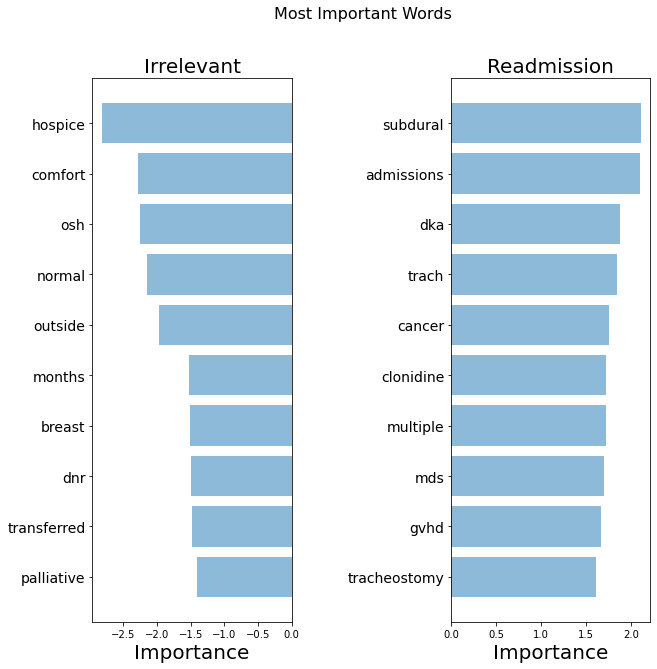

In [104]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

figure = plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most Important Words")

In [105]:
#save the figure in the images folder
figure.savefig('images/Importance.png', bbox_inches='tight')

In [106]:
#stem the words
main_df['TEXT'] = main_df['TEXT'].apply(stem_text)

<ipython-input-106-ad27d0526f69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['TEXT'] = main_df['TEXT'].apply(stem_text)


In [107]:
#lemmatize the words
main_df['TEXT'] = main_df['TEXT'].apply(lemmatize_text)

<ipython-input-107-af167faa3fe4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['TEXT'] = main_df['TEXT'].apply(lemmatize_text)


In [108]:
main_df['TEXT'] = main_df['TEXT'].apply(' '.join)

<ipython-input-108-b88861841073>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['TEXT'] = main_df['TEXT'].apply(' '.join)


In [109]:
main_df['TEXT'][0]

'admiss date discharg date date of birth sex m servic medicin allergi no known allergi advers drug reaction attend first name lf chief complaint dizzi major surgic or invas procedur none histori of present ill histori of present ill mr known lastnam is a year old male with pmh notabl for metastat cancer unknown primari undergo chemo now present with lighheaded and hemoptysi pt is undergo chemo with gemcitabin for malign neoplasm of unknown primari with multipl bone muscl and soft tissu metastas he came to the hospit to start rt to l femur today pt report a coupl day of lightheaded nonposit pt report one episod of hemoptysi but none sinc then no sig lung lesion on chest ct wa schedul to have transfus on the day of admiss orthostat at dr name ni offic were lie bp pul regular at stand bp pul in the ed initi v were t p rr bp o ra per dr last name stitl rad onc pt gener ha sbp s s he receiv l n put out l urin he wa start on vanc infust but develop red itchi arm and it wa stop he wa given be

## Export Cleaned and Merged Dataset

Export the cleaned and merged dataset into the data folder. I am planning to preprocess the text data in the modeling notebook instead to adjust the preprocessing step to see how it affects the model performance.

In [110]:
#export the main dataframe to the data folder for analysis in the modeling notebook
main_df.to_csv("data/admissions_cleaned_3.csv.gz" , index = False,compression='gzip')